## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [ ]:
%matplotlib inline

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.notebook.showdoc import *

## Getting and converting the data

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [ ]:
fname = '09/frame_00667_rgb.jpg'

In [ ]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

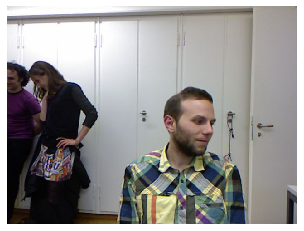

In [ ]:
img = PILImage.create(path/fname)
img.show();

In [ ]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [ ]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c1,c2])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return TensorPoint.create(pts, sz=img.size)

In [ ]:
get_ctr(fname)

tensor([428.5814, 263.9104])

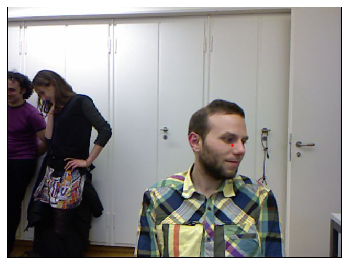

In [ ]:
ctr = get_ctr(fname)
ax = img.show(figsize=(6, 6))
get_ip(img, ctr).show(ctx=ax);

## Creating a dataset

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                   get_y=get_ctr)

In [ ]:
dbunch = dblock.databunch(path, path=path, bs=64, batch_tfms=[*aug_transforms(size=(120,160)), Normalize(*imagenet_stats)])

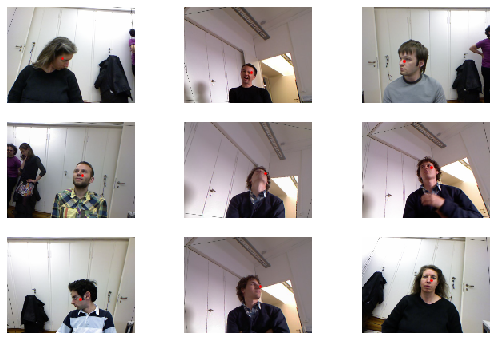

In [ ]:
dbunch.show_batch(max_n=9, figsize=(9,6))

## Train model

In [ ]:
#TODO: look in after_item for c
dbunch.c = dbunch.train_dl.after_item.c

In [ ]:
learn = cnn_learner(dbunch, resnet34)

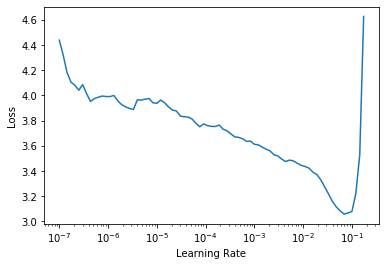

In [ ]:
learn.lr_find()

In [ ]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.146141,0.037040,00:31
1,0.045174,0.011963,00:29
2,0.016295,0.001562,00:28
3,0.009256,0.002951,00:29
4,0.007219,0.001400,00:30


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

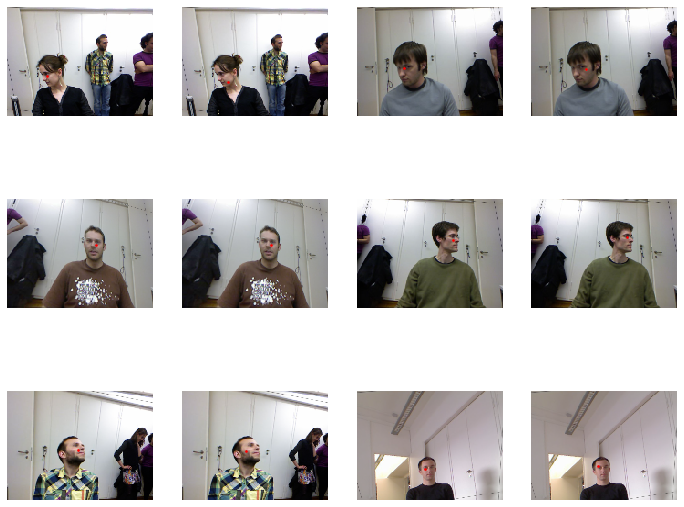

In [ ]:
learn.show_results(max_n=6)

## Data augmentation (not ported yet)

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

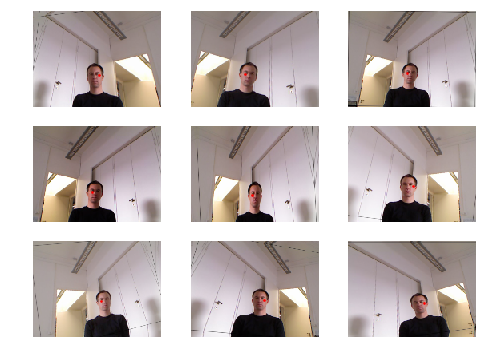

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))